In [2]:
from pathlib import Path

from astropy.io import fits
from matplotlib import rc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from qso import sdss

In [2]:
rc("font", family="serif")
rc("text", usetex=True)

In [3]:
SDSS_DIR = Path("data") / "sdss"
SDSS_DR14 = SDSS_DIR / "sdss_dr14"
SDSS_CATALOG = SDSS_DIR / "specObj-dr14.fits"
SDSS_QSO_CATALOG = SDSS_DIR / "DR14Q_v4_4.fits"
FIGS_DIR = Path("figs")

In [4]:
# wavelengths from `lamost_analysis.ipynb`
WAVEMIN, WAVEMAX = 3839.7244, 8914.597

# SDSS DR14 Optical Spectra Catalog

According to [data model](https://data.sdss.org/datamodel/files/SPECTRO_REDUX/specObj.html)
contains the list of all spectra for a given data release,
with associated parameters from the 2D and 1D pipelines for each.

In [5]:
with fits.open(SDSS_CATALOG) as catalog_hdul:
    catalog_hdul.info()
    catalog = catalog_hdul[1].data

n_spec = catalog.shape[0]

Filename: data/sdss/specObj-dr14.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU    283   4851200R x 133C   [6A, 4A, 16A, 27A, 16A, 8A, E, E, E, J, E, E, J, B, B, B, B, B, B, B, J, 22A, 19A, 19A, 22A, 20A, I, 4A, 7A, 7A, J, D, D, D, E, E, 22A, 8A, K, J, J, J, J, J, K, K, J, J, J, J, J, J, K, K, K, K, K, K, K, K, I, J, J, J, J, 5J, D, D, 6A, 21A, E, E, E, J, E, 24A, 10J, J, 10E, E, E, E, E, E, E, J, E, E, E, J, E, 5E, E, 10E, 10E, 10E, 5E, 5E, 5E, 5E, 5E, J, J, E, E, E, E, E, E, 25A, 21A, 12A, E, E, E, E, E, E, E, E, J, E, E, J, 6A, 21A, E, E, J, J, A, 5E, 5E]   


In [6]:
catalog["plate"].dtype, catalog["mjd"].dtype, catalog["fiberid"].dtype

(dtype('>i4'), dtype('>i4'), dtype('>i4'))

In [7]:
# convert dtypes to machine native
arrays = [
    catalog["plate"].astype("i4"),
    catalog["mjd"].astype("i4"),
    catalog["fiberid"].astype("i4")
]
multiindex = pd.MultiIndex.from_arrays(
    arrays,
    names=["plate", "mjd", "fiberid"]
)

data = {
    "platequality": pd.Categorical(catalog["platequality"]),
    "targettype": pd.Categorical(catalog["targettype"]),
    "wavemax": catalog["wavemax"].astype("f4"),
    "wavemin": catalog["wavemin"].astype("f4"),
    "zwarning": catalog["zwarning"].astype("i4")
}
catalog_df = pd.DataFrame(data, index=multiindex).sort_index()

catalog_df.info()
catalog_df.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4851200 entries, (266, 51602, 1) to (10000, 57346, 1000)
Data columns (total 5 columns):
platequality    category
targettype      category
wavemax         float32
wavemin         float32
zwarning        int32
dtypes: category(2), float32(2), int32(1)
memory usage: 92.6 MB


platequality targettype      wavemax      wavemin  \
plate mjd   fiberid                                                     
266   51602 1           bad        SCIENCE   9202.376953  3806.273682   
            2           bad        SCIENCE   9202.376953  3806.273682   
            3           bad        SCIENCE   9202.376953  3806.273682   
            4           bad        SCIENCE   9202.376953  3806.273682   
            5           bad        SCIENCE   9202.376953  3805.397217   

                     zwarning  
plate mjd   fiberid            
266   51602 1               0  
            2               0  
            3               0  
            4               0  
            5               0

In [8]:
catalog_df.loc[catalog_df["wavemax"] == 0.0, "wavemax"] = np.nan
catalog_df.loc[catalog_df["wavemin"] == 0.0, "wavemin"] = np.nan

In [9]:
zwarning = catalog_df["zwarning"].values

# https://www.sdss.org/dr13/algorithms/bitmasks/#ZWARNING
unplugged_idx = np.bitwise_and(zwarning, 2 ** 7).astype("bool")
nodata_idx = np.bitwise_and(zwarning, 2 ** 9).astype("bool")

catalog_df["unplugged"] = False
catalog_df.loc[unplugged_idx, "unplugged"] = True
catalog_df["nodata"] = False
catalog_df.loc[nodata_idx, "nodata"] = True

catalog_df.head()

platequality targettype      wavemax      wavemin  \
plate mjd   fiberid                                                     
266   51602 1           bad        SCIENCE   9202.376953  3806.273682   
            2           bad        SCIENCE   9202.376953  3806.273682   
            3           bad        SCIENCE   9202.376953  3806.273682   
            4           bad        SCIENCE   9202.376953  3806.273682   
            5           bad        SCIENCE   9202.376953  3805.397217   

                     zwarning  unplugged  nodata  
plate mjd   fiberid                               
266   51602 1               0      False   False  
            2               0      False   False  
            3               0      False   False  
            4               0      False   False  
            5               0      False   False

# SDSS DR14 Quasar Catalog

Known problems of the catalog are listed in a Jupyter notebook
[Preparing SDSS DR14 VACs](https://github.com/noaodatalab/digestor/blob/master/docs/notebooks/Preparing_SDSS_DR14_VACs.ipynb)
where VACs value added catalogs.

In [10]:
with fits.open(SDSS_QSO_CATALOG) as qso_hdul:
    qso_hdul.info()
    qso_catalog = qso_hdul[1].data

Filename: data/sdss/DR14Q_v4_4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (7055,)   uint8   
  1  DR14Q_v4_4    1 BinTableHDU    328   526356R x 105C   [18A, D, D, J, I, J, I, 4A, D, D, 4A, D, D, D, I, D, D, D, K, K, K, K, K, K, I, I, I, 51J, 51J, 51J, 51A, D, D, I, A, I, I, A, 5D, 5D, 5D, 5D, D, 5D, D, D, D, D, D, D, D, D, D, D, D, E, D, D, D, D, D, D, E, I, D, D, E, I, D, D, E, I, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 4A, 4A, D, E, D, D, D, D, D, D, D, D, I, D, D, D]   


In [11]:
n_primary = qso_catalog.shape[0]
n_additional = qso_catalog["n_spec"].sum()
n_primary, n_additional, n_primary + n_additional

(526356, 123435, 649791)

In [12]:
def get_duplicate_spec(duplicate):
    return duplicate[duplicate > 0]

plate_duplicate   = get_duplicate_spec(qso_catalog["plate_duplicate"])
mjd_duplicate     = get_duplicate_spec(qso_catalog["mjd_duplicate"])
fiberid_duplicate = get_duplicate_spec(qso_catalog["fiberid_duplicate"])

plate_duplicate.shape, mjd_duplicate.shape, fiberid_duplicate.shape

((103156,), (103156,), (103156,))

In [13]:
n_true_additional = plate_duplicate.shape[0]
n_qso = n_primary + n_true_additional
n_true_additional, n_qso, (n_primary + n_additional) - n_qso

(103156, 629512, 20279)

In [14]:
qso_catalog["plate"].dtype, qso_catalog["mjd"].dtype, qso_catalog["fiberid"].dtype

(dtype('>i2'), dtype('>i4'), dtype('>i2'))

In [15]:
def fill_array(arr, primaries, duplicates, n_primary=n_primary):
    arr[:n_primary] = primaries
    arr[n_primary:] = duplicates

plate   = np.zeros(shape=n_qso, dtype='i2')
mjd     = np.zeros(shape=n_qso, dtype='i4')
fiberid = np.zeros(shape=n_qso, dtype='i2')

fill_array(plate, qso_catalog["plate"], plate_duplicate)
fill_array(mjd, qso_catalog["mjd"], mjd_duplicate)
fill_array(fiberid, qso_catalog["fiberid"], fiberid_duplicate)

# Combining

In [16]:
qso_multiindex = pd.MultiIndex.from_arrays(
    [plate, mjd, fiberid],
    names=["plate", "mjd", "fiberid"]
)

qso_missing = qso_multiindex.difference(multiindex)
qso_multiindex = qso_multiindex.difference(qso_missing)
qso_multiindex.shape

(629457,)

In [17]:
qso_missing.shape, qso_missing

((55,), MultiIndex([(2516, 54240,  21),
             (2516, 54240,  64),
             (2516, 54240,  93),
             (2516, 54240,  98),
             (2516, 54240,  99),
             (2516, 54240, 119),
             (2516, 54240, 122),
             (2516, 54240, 125),
             (2516, 54240, 157),
             (2516, 54240, 165),
             (2516, 54240, 188),
             (2516, 54240, 196),
             (2516, 54240, 197),
             (2516, 54240, 201),
             (2516, 54240, 213),
             (2516, 54240, 218),
             (2516, 54240, 250),
             (2516, 54240, 289),
             (2516, 54240, 303),
             (2516, 54240, 330),
             (2516, 54240, 342),
             (2516, 54240, 346),
             (2516, 54240, 362),
             (2516, 54240, 369),
             (2516, 54240, 394),
             (2516, 54240, 407),
             (2516, 54240, 419),
             (2516, 54240, 424),
             (2516, 54240, 467),
             (2516, 54240, 472),
   

In [18]:
catalog_df["qso"] = False
catalog_df.loc[qso_multiindex, "qso"] = True
catalog_df.head()

platequality targettype      wavemax      wavemin  \
plate mjd   fiberid                                                     
266   51602 1           bad        SCIENCE   9202.376953  3806.273682   
            2           bad        SCIENCE   9202.376953  3806.273682   
            3           bad        SCIENCE   9202.376953  3806.273682   
            4           bad        SCIENCE   9202.376953  3806.273682   
            5           bad        SCIENCE   9202.376953  3805.397217   

                     zwarning  unplugged  nodata    qso  
plate mjd   fiberid                                      
266   51602 1               0      False   False  False  
            2               0      False   False  False  
            3               0      False   False  False  
            4               0      False   False  False  
            5               0      False   False  False

In [19]:
catalog_df["qso"].sum()

629457

# Analysis

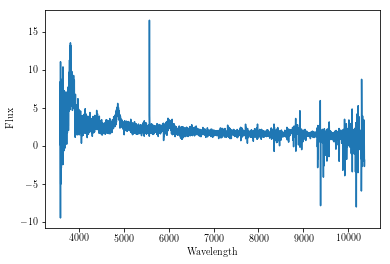

In [20]:
def plot_spec(plate, mjd, fiberid):
    dr_path = sdss.get_dr_path(plate, mjd, fiberid)
    filepath = SDSS_DR14 / dr_path
    with fits.open(filepath) as hdul:
        data = hdul[1].data
        ax = plt.axes(xlabel="Wavelength", ylabel="Flux")
        ax.plot(np.power(10, data["loglam"]), data["flux"])

a_qso = catalog_df[catalog_df["qso"]].sample()
plot_spec(*a_qso.index[0])

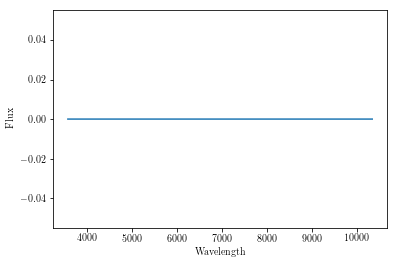

In [21]:
a_nodata_spec = catalog_df[catalog_df["nodata"]].sample()
plot_spec(*a_nodata_spec.index[0])

In [22]:
np.all(catalog_df["wavemin"].isna() == catalog_df["wavemax"].isna())

True

Text(0.5, 0, 'Maximal wavelength (\\AA{})')

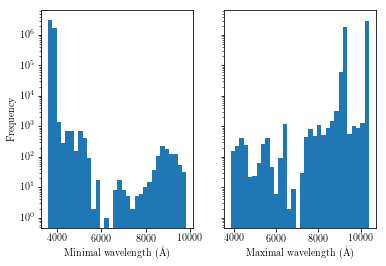

In [23]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
catalog_df["wavemin"].plot.hist(ax=ax1, bins=32, log=True)
catalog_df["wavemax"].plot.hist(ax=ax2, bins=32, log=True)
ax1.set_xlabel("Minimal wavelength (\AA{})")
ax2.set_xlabel("Maximal wavelength (\AA{})")

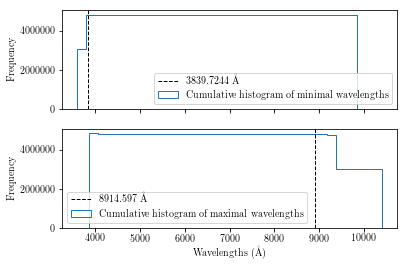

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.set_xlabel("Wavelengths (\AA{})")
ax2.set_xlabel("Wavelengths (\AA{})")
catalog_df["wavemin"].plot.hist(
    ax=ax1, histtype='step', bins=32, cumulative=True,
    label="Cumulative histogram of minimal wavelengths"
)
catalog_df["wavemax"].plot.hist(
    ax=ax2, histtype='step', bins=32, cumulative=-1,
    label="Cumulative histogram of maximal wavelengths"
)
axvline_style = {"linestyle": "dashed", "linewidth": 1, "color": "k"}
ax1.axvline(WAVEMIN, label=str(WAVEMIN) + " \AA{}", **axvline_style)
ax2.axvline(WAVEMAX, label=str(WAVEMAX) + " \AA{}", **axvline_style)
ax1.legend(loc="lower right")
ax2.legend(loc="lower left")
plt.savefig(str(FIGS_DIR / "waves_cumulative_hist.pdf"))

In [25]:
idx_selected = (catalog_df["wavemin"] <= WAVEMIN) & (WAVEMAX <= catalog_df["wavemax"])
n_selected = idx_selected.sum()
n_selected, n_spec - n_selected

(4816713, 34487)

In [26]:
catalog_selected_df = catalog_df[idx_selected]
catalog_selected_df.shape, catalog_df.shape

((4816713, 8), (4851200, 8))

In [27]:
catalog_df["qso"].sum() - catalog_selected_df["qso"].sum()

1949

In [28]:
catalog_selected_df["qso"].sum()

627508

# Dataset

In [29]:
N_TRAIN = 1000000
N_VALID = 50000
SIZE = N_TRAIN + N_VALID

In [30]:
sample_df = catalog_selected_df.sample(SIZE, random_state=9)
sample_df.iloc[:N_TRAIN]["qso"].sum(), sample_df.iloc[N_TRAIN:]["qso"].sum()

(130904, 6552)